# Associate spindle/ripples and Ca2+ signal

In [2]:
import quantities as pq
import numpy as np
import neo
from pathlib import Path
import xarray as xr
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
%matplotlib widget

from ephyviewer import mkQApp, MainViewer, TraceViewer

from minian.utilities import (
    TaskAnnotation,
    get_optimal_chk,
    load_videos,
    open_minian,
    save_minian,
)

objc[4398]: Class QMacAutoReleasePoolTracker is implemented in both /opt/anaconda3/envs/minian/lib/libQt5Core.5.12.9.dylib (0x138d96528) and /opt/anaconda3/envs/minian/lib/python3.8/site-packages/cv2/.dylibs/QtCore (0x1449ca700). One of the two will be used. Which one is undefined.
objc[4398]: Class QT_ROOT_LEVEL_POOL__THESE_OBJECTS_WILL_BE_RELEASED_WHEN_QAPP_GOES_OUT_OF_SCOPE is implemented in both /opt/anaconda3/envs/minian/lib/libQt5Core.5.12.9.dylib (0x138d965a0) and /opt/anaconda3/envs/minian/lib/python3.8/site-packages/cv2/.dylibs/QtCore (0x1449ca778). One of the two will be used. Which one is undefined.
objc[4398]: Class KeyValueObserver is implemented in both /opt/anaconda3/envs/minian/lib/libQt5Core.5.12.9.dylib (0x138d965c8) and /opt/anaconda3/envs/minian/lib/python3.8/site-packages/cv2/.dylibs/QtCore (0x1449ca7a0). One of the two will be used. Which one is undefined.
objc[4398]: Class RunLoopModeTracker is implemented in both /opt/anaconda3/envs/minian/lib/libQt5Core.5.12.9.

Load sleep score and Ca2+ time series numpy arrays

In [3]:
folder_base = Path('Gaelle/Baseline_recording/BlackLinesOK/session4/')

folder_Ephys = folder_base / f'OpenEphys/'
folder_Minis = folder_base / f'V4_Miniscope/minian/'

filenameE = folder_Ephys / f'SWRproperties.csv'
SWRprop = pd.read_csv(filenameE)
filenameE = folder_Ephys / f'Spindleproperties_PFC.csv'
PFCspiprop = pd.read_csv(filenameE)
filenameE = folder_Ephys / f'Spindleproperties_S1.csv'
S1spiprop = pd.read_csv(filenameE)
filenameB = folder_base / f'SynchroFile.xlsx'
stamps = pd.read_excel(filenameB)
filenameU = folder_Minis / f'UniTtoKeep.xlsx'
UnitToKeep = pd.read_excel(filenameU)
UnitToKeepL = UnitToKeep[0].to_list()
minian_ds = open_minian(folder_Minis)


for file_path in folder_base.glob('**/*timeStamps.csv'):
    subfolder = file_path.parents[0].stem
    if subfolder == 'V4_Miniscope':
        stamps_miniscope = pd.read_csv(file_path)

Acq_freq = (list(stamps[0])[2])

TodropFile = folder_Minis / f'TodropFile.json'
with open(TodropFile, 'r') as f:
    unit_to_drop = json.load(f)
TodropFile = folder_Minis / f'AllunitsFile.json'
with open(TodropFile, 'r') as f:
    All_units = json.load(f)

UnitToKeepInd = [e for e, elem in enumerate(All_units) if elem in UnitToKeepL]
UnitToKeepInd

[0, 1, 2, 3]

In [4]:
All_units

[11, 18, 24, 25]

Adjust start time on ephys and remove unit to drop on Minian

In [5]:
S1spiprop[["peak time", "start time", "end time"]] = S1spiprop[["peak time", "start time", "end time"]]-(list(stamps[0])[0]*1000)
PFCspiprop[["peak time", "start time", "end time"]] = PFCspiprop[["peak time", "start time", "end time"]]-(list(stamps[0])[0]*1000)
SWRprop[["peak time", "start time", "end time"]] = SWRprop[["peak time", "start time", "end time"]]-(list(stamps[0])[0]*1000)
C = minian_ds['C']
A = minian_ds['A']
B = A['unit_id']
A = minian_ds['A']
B = A['unit_id']
copyB = list(B.copy())
for i in range(len(unit_to_drop)):
    elem = unit_to_drop[i]
    copyB.remove(elem)
unit_to_keep = copyB

C = C.loc[unit_to_keep,:]
nb_unit = C.shape[0]
rec_dur = C.shape[1]
print(nb_unit)

4


In [6]:
from bisect import bisect_left

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before

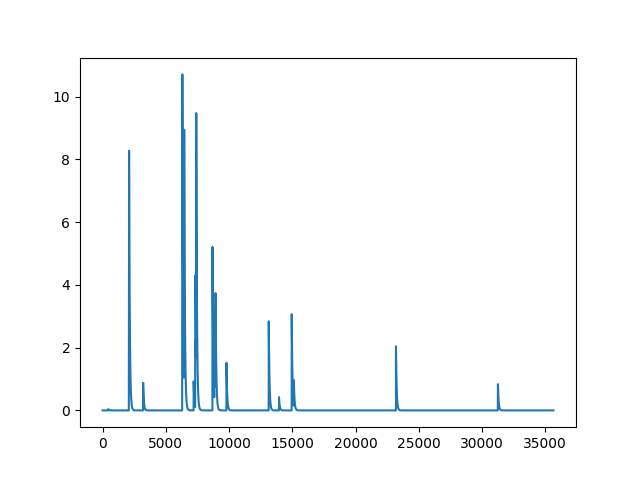

In [7]:
Cseries = C.to_series()
unit = 0
lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
lCseries
time = range(rec_dur)
plt.close()
plt.plot(time, lCseries)
plt.show()

Option 1: For each cell, avg activity 3s around the onset of spindles

In [8]:
Cseries = C.to_series()
unit = 1
duration = 3
Struct = "PFC"
lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
ActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
ActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
ActivityCa_SWR = pd.Series(np.zeros(duration*2*Acq_freq))
time = range(duration*2*Acq_freq)
Half = int(ActivityCa_S1spin.shape[0]/2)
TimeStamps_miniscope = list(stamps_miniscope["Time Stamp (ms)"])
plt.close()
if Struct == 'S1':
    nb_spindle = S1spiprop.shape[0]
    AVGActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
    print(nb_spindle)
    for unit in range(nb_unit):
        ActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
        lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
        for Pspin in range(nb_spindle):
            ser = pd.Series(S1spiprop["start time"])
            Frame_Spindle_start = take_closest(TimeStamps_miniscope, ser[Pspin])
            index = TimeStamps_miniscope.index(Frame_Spindle_start)
            trace = list(lCseries[index-Half:index+Half])
            if len(trace)<len(time):
                print(Pspin)
            else:
                ActivityCa_S1spin = ActivityCa_S1spin+list(lCseries[index-Half:index+Half])
        nActivityCa_S1spin = ActivityCa_S1spin/max(ActivityCa_S1spin)
        AVGActivityCa_S1spin = AVGActivityCa_S1spin + ActivityCa_S1spin
    plt.plot(time, AVGActivityCa_S1spin)
elif Struct == 'PFC':
    nb_spindle = PFCspiprop.shape[0]
    AVGActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
    for unit in range(nb_unit):
        ActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
        lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
        for Pspin in range(nb_spindle):
            ser = pd.Series(PFCspiprop["start time"])
            Frame_Spindle_start = take_closest(TimeStamps_miniscope, ser[Pspin])
            index = TimeStamps_miniscope.index(Frame_Spindle_start)
            trace = list(lCseries[index-Half:index+Half])
            if len(trace)<len(time):
                print(Pspin)
            else:
                ActivityCa_PFCspin = ActivityCa_PFCspin+list(lCseries[index-Half:index+Half])
        nActivityCa_PFCspin = ActivityCa_PFCspin/max(ActivityCa_PFCspin)
        AVGActivityCa_PFCspin = AVGActivityCa_PFCspin + ActivityCa_PFCspin
    plt.plot(time, AVGActivityCa_PFCspin)

elif Struct == 'CA1':
    nb_swr = SWRprop.shape[0]
    print(nb_swr)
    for Pswr in range(50,nb_swr-50):
        ser = pd.Series(SWRprop["start time"])
        Frame_SWR_start = take_closest(TimeStamps_miniscope, ser[Pswr])
        index = TimeStamps_miniscope.index(Frame_SWR_start)
        trace = list(lCseries[index-Half:index+Half])
        ActivityCa_SWR = ActivityCa_SWR+list(lCseries[index-Half:index+Half])
        plt.plot(time, trace)

#plt.close()
#plt.plot(time, ActivityCa_PFCspin)
plt.show()

NameError: name 'stamps_miniscope' is not defined

Same here but with a selection of neurons

In [ ]:
Cseries = C.to_series()
unit_to_keep = UnitToKeepInd
duration = 3
Struct = "S1"
lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
ActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
ActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
ActivityCa_SWR = pd.Series(np.zeros(duration*2*Acq_freq))
time = range(duration*2*Acq_freq)
Half = int(ActivityCa_S1spin.shape[0]/2)
TimeStamps_miniscope = list(stamps_miniscope["Time Stamp (ms)"])
plt.close()
if Struct == 'S1':
    nb_spindle = S1spiprop.shape[0]
    AVGActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
    print(nb_spindle)
    for unit in unit_to_keep:
        ActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
        lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
        for Pspin in range(nb_spindle):
            ser = pd.Series(S1spiprop["start time"])
            Frame_Spindle_start = take_closest(TimeStamps_miniscope, ser[Pspin])
            index = TimeStamps_miniscope.index(Frame_Spindle_start)
            trace = list(lCseries[index-Half:index+Half])
            if len(trace)<len(time):
                print(Pspin)
            else:
                ActivityCa_S1spin = ActivityCa_S1spin+list(lCseries[index-Half:index+Half])
        nActivityCa_S1spin = ActivityCa_S1spin/max(ActivityCa_S1spin)
        AVGActivityCa_S1spin = AVGActivityCa_S1spin + ActivityCa_S1spin
    plt.plot(time, AVGActivityCa_S1spin)
elif Struct == 'PFC':
    nb_spindle = PFCspiprop.shape[0]
    AVGActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
    for unit in unit_to_keep:
        ActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
        lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
        for Pspin in range(nb_spindle):
            ser = pd.Series(PFCspiprop["start time"])
            Frame_Spindle_start = take_closest(TimeStamps_miniscope, ser[Pspin])
            index = TimeStamps_miniscope.index(Frame_Spindle_start)
            trace = list(lCseries[index-Half:index+Half])
            if len(trace)<len(time):
                print(Pspin)
            else:
                ActivityCa_PFCspin = ActivityCa_PFCspin+list(lCseries[index-Half:index+Half])
        nActivityCa_PFCspin = ActivityCa_PFCspin/max(ActivityCa_PFCspin)
        AVGActivityCa_PFCspin = AVGActivityCa_PFCspin + ActivityCa_PFCspin
    plt.plot(time, AVGActivityCa_PFCspin)

#plt.close()
#plt.plot(time, ActivityCa_PFCspin)
plt.show()

NameError: name 'C' is not defined

focusing on the coordinated SWR and spindles

In [ ]:
Struct = "PFC"
before = 1000 # ms
after = 000 # ms
counterPFC = 0
counterS1 = 0
Coupled_spindlesPFC = list()
Coupled_spindlesS1 = list()
unCoupled_spindlesPFC = list()
unCoupled_spindlesS1 = list()

nb_spindle = PFCspiprop.shape[0]
for Pspin in range(nb_spindle-1):
    ser = pd.Series(PFCspiprop["start time"])
    serSWR = pd.Series(SWRprop["start time"])
    Combined_Spindle_SWR = take_closest(serSWR, ser[Pspin])
    distance = Combined_Spindle_SWR - ser[Pspin]
    if (distance > (- before)) and (distance <  after):
        counterPFC = counterPFC + 1
        Coupled_spindlesPFC.append(Pspin)
    else:
        unCoupled_spindlesPFC.append(Pspin)
nb_spindle = S1spiprop.shape[0]
for Pspin in range(nb_spindle-3):
    ser = pd.Series(S1spiprop["start time"])
    serSWR = pd.Series(SWRprop["start time"])
    Combined_Spindle_SWR = take_closest(serSWR, ser[Pspin])
    distance = Combined_Spindle_SWR - ser[Pspin]
    if (distance > (- before)) and (distance <  after):
        counterS1 = counterS1 + 1
        Coupled_spindlesS1.append(Pspin)
    else:
        unCoupled_spindlesS1.append(Pspin)

print(Coupled_spindlesPFC)
print(unCoupled_spindlesPFC)
print(len(Coupled_spindlesPFC)/(len(Coupled_spindlesPFC)+len(unCoupled_spindlesPFC)))

[0, 5, 8, 14, 15]
[1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18]
0.2631578947368421


Same as before but with coupled spindles

In [ ]:
duration = 2
Struct = "PFC"
lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
ActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
ActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
ActivityCa_SWR = pd.Series(np.zeros(duration*2*Acq_freq))
time = range(duration*2*Acq_freq)
Half = int(ActivityCa_S1spin.shape[0]/2)
TimeStamps_miniscope = list(stamps_miniscope["Time Stamp (ms)"])
plt.close()
if Struct == 'S1':
    nb_spindle = S1spiprop.shape[0]
    AVGActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
    print(nb_spindle)
    for unit in range(nb_unit):
        ActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
        lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
        for Pspin in unCoupled_spindlesS1:
            ser = pd.Series(S1spiprop["start time"])
            Frame_Spindle_start = take_closest(TimeStamps_miniscope, ser[Pspin])
            index = TimeStamps_miniscope.index(Frame_Spindle_start)
            trace = list(lCseries[index-Half:index+Half])
            if len(trace)<len(time):
                print(Pspin)
            else:
                ActivityCa_S1spin = ActivityCa_S1spin+list(lCseries[index-Half:index+Half])
        nActivityCa_S1spin = ActivityCa_S1spin/max(ActivityCa_S1spin)
        AVGActivityCa_S1spin = AVGActivityCa_S1spin + ActivityCa_S1spin
    nAVGActivityCa_S1spin = AVGActivityCa_S1spin/max(AVGActivityCa_S1spin)
    plt.plot(time, nAVGActivityCa_S1spin)
elif Struct == 'PFC':
    nb_spindle = PFCspiprop.shape[0]
    AVGActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
    for unit in range(nb_unit):
        ActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
        lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
        for Pspin in Coupled_spindlesPFC:
            ser = pd.Series(PFCspiprop["start time"])
            Frame_Spindle_start = take_closest(TimeStamps_miniscope, ser[Pspin])
            index = TimeStamps_miniscope.index(Frame_Spindle_start)
            trace = list(lCseries[index-Half:index+Half])
            if len(trace)<len(time):
                print(Pspin)
            else:
                ActivityCa_PFCspin = ActivityCa_PFCspin+list(lCseries[index-Half:index+Half])
        nActivityCa_PFCspin = ActivityCa_PFCspin/max(ActivityCa_PFCspin)
        AVGActivityCa_PFCspin = AVGActivityCa_PFCspin + ActivityCa_PFCspin
    nAVGActivityCa_PFCspin = AVGActivityCa_PFCspin/max(AVGActivityCa_PFCspin)
    plt.plot(time, nAVGActivityCa_PFCspin)


#plt.close()
#plt.plot(time, ActivityCa_PFCspin)
plt.show()

In [ ]:
UnitToKeepInd

[1, 2, 3, 4, 5, 6]

Coupled spindles + selected units

0
5
8
14
15
71.48890412644124 160.25772587233226
7.034800747188209 15.77001610928859
18
18
18
18
18
1
2
3
4
6
7
9
10
11
12
13
16
17
18
151.76164414415092 98.48535138554212
15.779917587015488 10.240339297562974


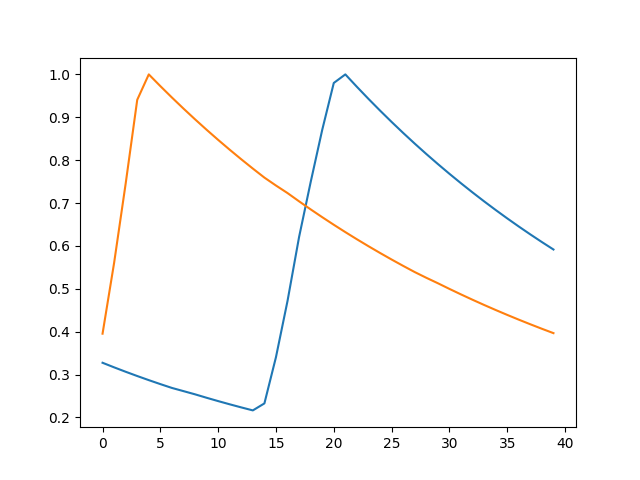

In [ ]:
Cseries = C.to_series()
unit_to_keep = UnitToKeepInd
#unit_to_keep = [3, 6]
duration = 1
Struct = "PFC"
lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
ActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
ActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
ActivityCa_SWR = pd.Series(np.zeros(duration*2*Acq_freq))
time = range(duration*2*Acq_freq)
Half = int(ActivityCa_S1spin.shape[0]/2)
TimeStamps_miniscope = list(stamps_miniscope["Time Stamp (ms)"])
plt.close()
if Struct == 'S1':
    AVGActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
    for unit in unit_to_keep:
    
        ActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
        lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
        for Pspin in Coupled_spindlesS1:
            ser = pd.Series(S1spiprop["start time"])
            Frame_Spindle_start = take_closest(TimeStamps_miniscope, ser[Pspin])
            index = TimeStamps_miniscope.index(Frame_Spindle_start)
            trace = list(lCseries[index-Half:index+Half])
            if len(trace)<len(time):
                print(Pspin)
            else:
                ActivityCa_S1spin = ActivityCa_S1spin+list(lCseries[index-Half:index+Half])
        nActivityCa_S1spin = ActivityCa_S1spin/max(ActivityCa_S1spin)
        AVGActivityCa_S1spin = AVGActivityCa_S1spin + ActivityCa_S1spin
    nAVGActivityCa_S1spin = AVGActivityCa_S1spin/max(AVGActivityCa_S1spin)
    plt.plot(time, nAVGActivityCa_S1spin)
    AVGActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
    for unit in unit_to_keep:
        ActivityCa_S1spin = pd.Series(np.zeros(duration*2*Acq_freq))
        lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
        for Pspin in unCoupled_spindlesS1:
            ser = pd.Series(S1spiprop["start time"])
            Frame_Spindle_start = take_closest(TimeStamps_miniscope, ser[Pspin])
            index = TimeStamps_miniscope.index(Frame_Spindle_start)
            trace = list(lCseries[index-Half:index+Half])
            if len(trace)<len(time):
                print(Pspin)
            else:
                ActivityCa_S1spin = ActivityCa_S1spin+list(lCseries[index-Half:index+Half])
        nActivityCa_S1spin = ActivityCa_S1spin/max(ActivityCa_S1spin)
        AVGActivityCa_S1spin = AVGActivityCa_S1spin + ActivityCa_S1spin
    nAVGActivityCa_S1spin = AVGActivityCa_S1spin/max(AVGActivityCa_S1spin)
    plt.plot(time, nAVGActivityCa_S1spin)

elif Struct == 'PFC':
    AVGActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
    for unit in unit_to_keep:
        ActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
        lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
        for Pspin in Coupled_spindlesPFC:
            ser = pd.Series(PFCspiprop["start time"])
            Frame_Spindle_start = take_closest(TimeStamps_miniscope, ser[Pspin])
            index = TimeStamps_miniscope.index(Frame_Spindle_start)
            trace = list(lCseries[index-Half:index+Half])
            if len(trace)<len(time):
                print(Pspin)
            else:
                ActivityCa_PFCspin = ActivityCa_PFCspin+list(lCseries[index-Half:index+Half])
        nActivityCa_PFCspin = ActivityCa_PFCspin/max(ActivityCa_PFCspin)
        AVGActivityCa_PFCspin = AVGActivityCa_PFCspin + ActivityCa_PFCspin    
    nAVGActivityCa_PFCspin = AVGActivityCa_PFCspin/max(AVGActivityCa_PFCspin)
    plt.plot(time, nAVGActivityCa_PFCspin)  
    CactBefore = sum(AVGActivityCa_PFCspin[0:Half])
    CactAfter = sum(AVGActivityCa_PFCspin[Half:2*Half])
    print(CactBefore, CactAfter)
    nCactBefore = sum(nAVGActivityCa_PFCspin[0:Half])
    nCactAfter = sum(nAVGActivityCa_PFCspin[Half:2*Half])
    print(nCactBefore, nCactAfter) 
    AVGActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
    for unit in unit_to_keep:
        ActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
        lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
        for Pspin in unCoupled_spindlesPFC:
            ser = pd.Series(PFCspiprop["start time"])
            Frame_Spindle_start = take_closest(TimeStamps_miniscope, ser[Pspin])
            index = TimeStamps_miniscope.index(Frame_Spindle_start)
            trace = list(lCseries[index-Half:index+Half])
            if len(trace)<len(time):
                print(Pspin)
            else:
                ActivityCa_PFCspin = ActivityCa_PFCspin+list(lCseries[index-Half:index+Half])
        nActivityCa_PFCspin = ActivityCa_PFCspin/max(ActivityCa_PFCspin)
        AVGActivityCa_PFCspin = AVGActivityCa_PFCspin + ActivityCa_PFCspin
    nAVGActivityCa_PFCspin = AVGActivityCa_PFCspin/max(AVGActivityCa_PFCspin)
    plt.plot(time, nAVGActivityCa_PFCspin)
    unCactBefore = sum(AVGActivityCa_PFCspin[0:Half])
    unCactAfter = sum(AVGActivityCa_PFCspin[Half:2*Half])
    print(unCactBefore, unCactAfter)
    nunCactBefore = sum(nAVGActivityCa_PFCspin[0:Half])
    nunCactAfter = sum(nAVGActivityCa_PFCspin[Half:2*Half])
    print(nunCactBefore, nunCactAfter)

#plt.close()
#plt.plot(time, ActivityCa_PFCspin)
plt.show()

In [ ]:
negCoupledBef = CactBefore
negCoupledAft = CactAfter
negunCoupledBef = unCactBefore
negunCoupledAft = unCactAfter
nnegCoupledBef = nCactBefore
nnegCoupledAft = nCactAfter
nnegunCoupledBef = nunCactBefore
nnegunCoupledAft = nunCactAfter

In [ ]:
posCoupledBef = CactBefore
posCoupledAft = CactAfter
posunCoupledBef = unCactBefore
posunCoupledAft = unCactAfter
nposCoupledBef = nCactBefore
nposCoupledAft = nCactAfter
nposunCoupledBef = nunCactBefore
nposunCoupledAft = nunCactAfter

In [ ]:
outSumm = pd.Series([negCoupledBef, negCoupledAft, negunCoupledBef, negunCoupledAft, nnegCoupledBef, nnegCoupledAft, nnegunCoupledBef, nnegunCoupledAft, posCoupledBef, posCoupledAft, posunCoupledBef, posunCoupledAft, nposCoupledBef, nposCoupledAft, nposunCoupledBef, nposunCoupledAft],
              index=["NCB", "NCA", "N1CB", "N1CA", "nNCB", "nNCA", "nN1CB", "nN1CB", "PCB", "PCA", "P1CB", "P1CA", "nPCB", "nPC1", "nP1CB", "nP1CA"])


filenameOut = folder_base / f'Ca2+intSWRspindles.xlsx'
writer = pd.ExcelWriter(filenameOut)
outSumm.to_excel(writer)
writer.save()